In [1]:
%load_ext lab_black

In [2]:
%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

In [5]:
import os

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
m_df = pd.read_sql_table("measurement", engine)
m_df[["prcp"]].describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [13]:
# Design a query to show how many stations are available in this dataset?
# session.query(Station).count()
session.query(Measurement.station).distinct().count()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
s_id = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
s_id

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?

session.query(
    func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)
).filter(Measurement.station == s_id[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [16]:
max_date = dt.datetime.strptime(
    session.query(func.max(Measurement.date)).first()[0], "%Y-%m-%d"
)
yr_prev = dt.datetime(max_date.year - 1, max_date.month, max_date.day)

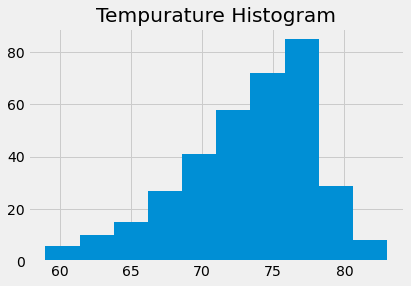

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_results = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == s_id[0][0])
    .filter(Measurement.date.between(yr_prev, max_date))
    .all()
)
tobs = [(r[0]) for r in tobs_results]
plt.title("Tempurature Histogram")
plt.hist(tobs)
plt.savefig(os.path.join("Images", "Temp_hist.png"))
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2015-05-01", "2015-05-10"))

[(67.0, 73.703125, 78.0)]


In [19]:
trip_temps = (
    session.query(
        Measurement.date,
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    )
    .filter(Measurement.date >= "2015-05-01")
    .filter(Measurement.date <= "2015-05-10")
    .group_by(Measurement.date)
    .all()
)

In [20]:
trip_temp_df = pd.DataFrame(
    [list(row) for row in trip_temps], columns=["Date", "TMIN", "TMAX", "TAVG"]
).set_index("Date")

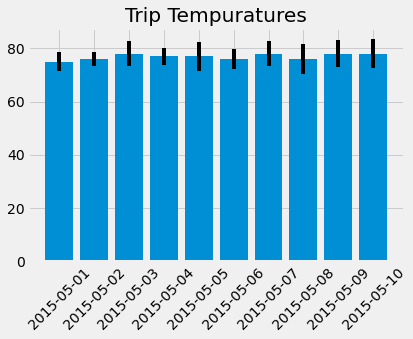

In [21]:
plt.title("Trip Tempuratures")
plt.bar(
    trip_temp_df.index,
    trip_temp_df["TAVG"],
    yerr=trip_temp_df["TMAX"] - trip_temp_df["TMIN"],
)
plt.xticks(rotation=45)
plt.savefig(os.path.join("Images", "Trip_Temp_Avg.png"))
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_prcp = (
    session.query(
        Measurement.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.sum(Measurement.prcp),
    )
    .filter(Measurement.date.between(yr_prev, max_date))
    .filter(Measurement.station == Station.station)
    .group_by(Measurement.station)
    .order_by(func.sum(Measurement.prcp).desc())
    .all()
)
pd.DataFrame(
    [list(row) for row in station_prcp],
    columns=[
        "Station ID",
        "Station name",
        "Latitude",
        "Longitude",
        "Elevation",
        "Total Rainfall",
    ],
).set_index("Station ID")

,Station name,Latitude,Longitude,Elevation,Total Rainfall
Station ID,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.11
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,68.24
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.36
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,37.99
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.19
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`